In [2]:
#Init
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
import numpy as np
import time
from numba import cuda

import matplotlib.pyplot as plt

from timeit import default_timer as timer

###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# init
###############
def init(dim, mesh_path):
  running_conf = Struct(backend="numba", signature=True, cache=True, float_precision="single")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  running_conf = Struct(backend="numba", signature=True, cache =True, float_precision="single")
  domain = Domain(dim=dim, conf=running_conf)
  ne = Variable(domain=domain)
  u  = Variable(domain=domain)
  v  = Variable(domain=domain)
  w  = Variable(domain=domain)
  
  P = Variable(domain=domain)
  Pinit = 2.0
  cells = domain.cells
  initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, cells.center, Pinit)

  u.face[:] = 2.
  v.face[:] = 0.
  w.face[:] = 0.
  
  u.interpolate_facetocell()
  v.interpolate_facetocell()
  w.interpolate_facetocell()
  return (domain, ne, u, v, w, P)

In [3]:
#Domain
dim = 2
mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre_hybrid.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square_larger.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square_larger.msh"
domain, ne, u, v, w, P = init(dim=dim, mesh_path=mesh_file)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 105826
Number of Vertices: 53314
Local domain contruction ...


In [4]:
#PETScKrylovSolver
from manapy.solvers.ls import PETScKrylovSolver

# put this code to PETScKrylovSolver init function so bypass the import of petsc4py
"""
    # try_imports(['import petsc4py',],
    #             'cannot import petsc4py solver!')
    
    # from petsc4py import PETSc as petsc
    
    #self.petsc = petsc
    self.ksp   = None
    
    self.converged_reasons = {}                                                                                                                                                                             
    # for key, val in six.iteritems(petsc.KSP.ConvergedReason.__dict__):                                                                                                                                 
    #     if isinstance(val, int):                                                                                                                                                                       
    #         self.converged_reasons[val] = key    
"""

conf = Struct(reuse_mtx=True, scheme='diamond', verbose=False, precision="single")
L = PETScKrylovSolver(domain=domain, var=P, conf=conf)

SetUp the Linear system ...


In [5]:
#vars
from numba import cuda

def create_var(v):
  return (v, cuda.to_device(v))

host_cellfid, d_cellfid = create_var(L.domain.faces.cellid)
host_nodeidf, d_nodeidf = create_var(L.domain.faces.nodeid)
host_vertexn, d_vertexn = create_var(L.domain.nodes.vertex)
host_halofid, d_halofid = create_var(L.domain.faces.halofid)
host_haloext, d_haloext = create_var(L.domain.halos.halosext)
host_oldnamen, d_oldnamen = create_var(L.domain.nodes.oldname)
host_volume, d_volume = create_var(L.domain.cells.volume)
host_cellnid, d_cellnid = create_var(L.domain.nodes.cellid)
host_centerc, d_centerc = create_var(L.domain.cells.center)
host_centerh, d_centerh = create_var(L.domain.halos.centvol)
host_halonid, d_halonid = create_var(L.domain.nodes.halonid)
host_periodicnid, d_periodicnid = create_var(L.domain.nodes.periodicid)
host_centergn, d_centergn = create_var(L.domain.nodes.ghostcenter)
host_halocentergn, d_halocentergn = create_var(L.domain.nodes.haloghostcenter)
host_airDiamond, d_airDiamond = create_var(L.domain.faces.airDiamond)
host_lambda_x, d_lambda_x = create_var(L.domain.nodes.lambda_x)
host_lambda_y, d_lambda_y = create_var(L.domain.nodes.lambda_y)
host_lambda_z, d_lambda_z = create_var(L.domain.nodes.lambda_z)
host_number, d_number = create_var(L.domain.nodes.number)
host_R_x, d_R_x = create_var(L.domain.nodes.R_x)
host_R_y, d_R_y = create_var(L.domain.nodes.R_y)
host_R_z, d_R_z = create_var(L.domain.nodes.R_z)
host_param1, d_param1 = create_var(L.domain.faces.param1)
host_param2, d_param2 = create_var(L.domain.faces.param2)
host_param3, d_param3 = create_var(L.domain.faces.param3)
host_param4, d_param4 = create_var(L.domain.faces.param4)
host_shift, d_shift = create_var(L.domain.cells.shift)
host_nbelements, d_nbelements = create_var(L.localsize)
host_loctoglob, d_loctoglob = create_var(L.domain.cells.loctoglob)
host_BCdirichlet, d_BCdirichlet = create_var(L.var.BCdirichlet)
host_a_loc, d_a_loc = create_var(L._data)
host_irn_loc, d_irn_loc = create_var(L._row)
host_jcn_loc, d_jcn_loc = create_var(L._col)
host_matrixinnerfaces, d_matrixinnerfaces = create_var(L.matrixinnerfaces)
host_halofaces, d_halofaces = create_var(L.domain.halofaces)
host_dirichletfaces, d_dirichletfaces = create_var(L.var.dirichletfaces)


In [6]:
#The original function from functions2d.py

from numpy import  int32, float32, uint32
import numpy as np


def get_triplet_2d(cellfid:'int32[:,:]', nodeidf:'int32[:,:]', vertexn:'float[:,:]', halofid:'int32[:]',
                   haloext:'int32[:,:]', oldnamen:'uint32[:]', volume:'float[:]', 
                   cellnid:'int32[:,:]', centerc:'float[:,:]', centerh:'float[:,:]', halonid:'int32[:,:]', periodicnid:'int32[:,:]', 
                   centergn:'float[:,:,:]', halocentergn:'float[:,:,:]', airDiamond:'float[:]', 
                   lambda_x:'float[:]', lambda_y:'float[:]', lambda_z:'float[:]', number:'uint32[:]', R_x:'float[:]', R_y:'float[:]', 
                   R_z:'float[:]', param1:'float[:]', param2:'float[:]', param3:'float[:]', param4:'float[:]', shift:'float[:,:]',
                   nbelements:'int32', loctoglob:'int32[:]', BCdirichlet:'uint32[:]', a_loc:'float[:]', irn_loc:'int32[:]', jcn_loc:'int32[:]',
                   matrixinnerfaces:'uint32[:]', halofaces:'uint32[:]', dirichletfaces:'uint32[:]'):                                                                                                                                                                       
    
    
    def search_element(a:'int32[:]', target_value:'int32'):
        find = 0
        for val in a:
            if val == target_value:
                find = 1
                break
        return find
    center = np.zeros(2)
    parameters = np.zeros(2)
    cmpt = 0

    for i in matrixinnerfaces:
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        parameters[0] = param4[i]
        parameters[1] = param2[i]
    
        c_right = cellfid[i][1]
        c_rightglob = loctoglob[c_right]
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1
        
        cmptparam = 0
        


        for nod in nodeidf[i][:nodeidf[i][-1]]:
            if search_element(BCdirichlet, oldnamen[nod]) == 0: 
                for j in range(cellnid[nod][-1]):
                    center[:] = centerc[cellnid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                
                for j in range(len(centergn[nod])):
                    if centergn[nod][j][-1] != -1:
                        center[:] = centergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(centergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        irn_loc[cmpt] = c_rightglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1
                        
                for j in range(len(halocentergn[nod])):
                    if halocentergn[nod][j][-1] != -1:
                        center[:] = halocentergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(halocentergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        irn_loc[cmpt] = c_rightglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1
                    
                for j in range(periodicnid[nod][-1]):
                    if vertexn[nod][3] == 11 or vertexn[nod][3] == 22:
                        center[0] = centerc[periodicnid[nod][j]][0]  + shift[periodicnid[nod][j]][0]
                        center[1] = centerc[periodicnid[nod][j]][1]  
                    if vertexn[nod][3] == 33 or vertexn[nod][3] == 44:
                        center[0] = centerc[periodicnid[nod][j]][0]  
                        center[1] = centerc[periodicnid[nod][j]][1]  + shift[periodicnid[nod][j]][1]
                    
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[periodicnid[nod][j]]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = loctoglob[periodicnid[nod][j]]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                
                for j in range(halonid[nod][-1]):
                    center[:] = centerh[halonid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
            cmptparam =+1
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_rightglob
        value =  param3[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1

        # right cell------------------------------------------------------
        irn_loc[cmpt] = c_rightglob
        jcn_loc[cmpt] = c_leftglob
        value =  -1. * param1[i] / volume[c_right]
        a_loc[cmpt] = value
        cmpt = cmpt + 1
    
        irn_loc[cmpt] = c_rightglob
        jcn_loc[cmpt] = c_rightglob
        value =  -1. * param3[i] / volume[c_right]
        a_loc[cmpt] = value
        cmpt = cmpt + 1
    
    for i in halofaces:
        
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        parameters[0] = param4[i]
        parameters[1] = param2[i]
        
        c_rightglob = haloext[halofid[i]][0]
        c_right     = halofid[i]
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value =  param1[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1

        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_rightglob
        value =  param3[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1
        
        cmptparam = 0
        for nod in nodeidf[i][:nodeidf[i][-1]]:
            if search_element(BCdirichlet, oldnamen[nod]) == 0: 
                for j in range(cellnid[nod][-1]):
                    center[:] = centerc[cellnid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                    
                for j in range(len(centergn[nod])):
                    if centergn[nod][j][-1] != -1:
                        center[:] = centergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(centergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1
                        
                for j in range(len(halocentergn[nod])):
                    if halocentergn[nod][j][-1] != -1:
                        center[:] = halocentergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(halocentergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1

                for j in range(halonid[nod][-1]):
                    center[:] = centerh[halonid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
            cmptparam +=1
            
    for i in dirichletfaces:
        
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = -1. * param3[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1


In [7]:
#? using numba jit -> backend.py
#! Using parallel=True yields poor results.
import numba

numba_get_triplet_2d = numba.jit(get_triplet_2d, nopython=True, fastmath=True, parallel=False, cache=True)
def cpu_numba_get_triplet_2d():
  numba_get_triplet_2d(
    host_cellfid,
    host_nodeidf,
    host_vertexn,
    host_halofid,
    host_haloext,
    host_oldnamen,
    host_volume,
    host_cellnid,
    host_centerc,
    host_centerh,
    host_halonid,
    host_periodicnid,
    host_centergn,
    host_halocentergn,
    host_airDiamond,
    host_lambda_x,
    host_lambda_y,
    host_lambda_z,
    host_number,
    host_R_x,
    host_R_y,
    host_R_z,
    host_param1,
    host_param2,
    host_param3,
    host_param4,
    host_shift,
    host_nbelements,
    host_loctoglob,
    host_BCdirichlet,
    host_a_loc,
    host_irn_loc,
    host_jcn_loc,
    host_matrixinnerfaces,
    host_halofaces,
    host_dirichletfaces,
  )

cpu_numba_get_triplet_2d()


In [8]:
#time taken by cpu_numba_get_triplet_2d

initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, domain.cells.center, 2.0)

%timeit cpu_numba_get_triplet_2d()

108 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
@cuda.jit(device=True)
def search_element(a:'int32[:]', target_value:'int32'):
    for i in range(a.shape[0]):
        if a[i] == target_value:
            return 1
    return 0

@cuda.jit
def kernel_get_triplet_2d(cellfid:'int32[:,:]', nodeidf:'int32[:,:]', vertexn:'float[:,:]', halofid:'int32[:]',
                   haloext:'int32[:,:]', oldnamen:'uint32[:]', volume:'float[:]', 
                   cellnid:'int32[:,:]', centerc:'float[:,:]', centerh:'float[:,:]', halonid:'int32[:,:]', periodicnid:'int32[:,:]', 
                   centergn:'float[:,:,:]', halocentergn:'float[:,:,:]', airDiamond:'float[:]', 
                   lambda_x:'float[:]', lambda_y:'float[:]', lambda_z:'float[:]', number:'uint32[:]', R_x:'float[:]', R_y:'float[:]', 
                   R_z:'float[:]', param1:'float[:]', param2:'float[:]', param3:'float[:]', param4:'float[:]', shift:'float[:,:]',
                   nbelements:'int32', loctoglob:'int32[:]', BCdirichlet:'uint32[:]', a_loc:'float[:]', irn_loc:'int32[:]', jcn_loc:'int32[:]',
                   matrixinnerfaces:'uint32[:]', halofaces:'uint32[:]', dirichletfaces:'uint32[:]', s_cmpt):                                                                                                                                                                       
    
    
    idx = cuda.grid(1)
    parameters = numba.cuda.local.array(2, param4.dtype)


    if idx < matrixinnerfaces.shape[0]:
        i = matrixinnerfaces[idx]

        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        parameters[0] = param4[i]
        parameters[1] = param2[i]
    
        c_right = cellfid[i][1]
        c_rightglob = loctoglob[c_right]
        
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[cmpt] = value
        
        cmptparam = 0
        for nod in nodeidf[i][:nodeidf[i][-1]]:
            if search_element(BCdirichlet, oldnamen[nod]) == 0: 
                for j in range(cellnid[nod][-1]):
                    center = centerc[cellnid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value
                
                for j in range(len(centergn[nod])):
                    if centergn[nod][j][-1] != -1:
                        center = centergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(centergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                        irn_loc[cmpt] = c_rightglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value
                        
                for j in range(len(halocentergn[nod])):
                    if halocentergn[nod][j][-1] != -1:
                        center = halocentergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(halocentergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                        irn_loc[cmpt] = c_rightglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value
                    
                for j in range(periodicnid[nod][-1]):
                    if vertexn[nod][3] == 11 or vertexn[nod][3] == 22:
                        center[0] = centerc[periodicnid[nod][j]][0]  + shift[periodicnid[nod][j]][0]
                        center[1] = centerc[periodicnid[nod][j]][1]  
                    if vertexn[nod][3] == 33 or vertexn[nod][3] == 44:
                        center[0] = centerc[periodicnid[nod][j]][0]  
                        center[1] = centerc[periodicnid[nod][j]][1]  + shift[periodicnid[nod][j]][1]
                    
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[periodicnid[nod][j]]
                    a_loc[cmpt] = value
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = loctoglob[periodicnid[nod][j]]
                    a_loc[cmpt] = value
                
                for j in range(halonid[nod][-1]):
                    center = centerh[halonid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value
            cmptparam =+1
        
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_rightglob
        value =  param3[i] / volume[c_left]
        a_loc[cmpt] = value

        # right cell------------------------------------------------------
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_rightglob
        jcn_loc[cmpt] = c_leftglob
        value =  -1. * param1[i] / volume[c_right]
        a_loc[cmpt] = value
    
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_rightglob
        jcn_loc[cmpt] = c_rightglob
        value =  -1. * param3[i] / volume[c_right]
        a_loc[cmpt] = value
    
    if idx < halofaces.shape[0]:
        i = halofaces[idx]
        
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        parameters[0] = param4[i]; parameters[1] = param2[i]
        
        c_rightglob = haloext[halofid[i]][0]
        c_right     = halofid[i]
        
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value =  param1[i] / volume[c_left]
        a_loc[cmpt] = value

        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_rightglob
        value =  param3[i] / volume[c_left]
        a_loc[cmpt] = value
        
        cmptparam = 0
        for nod in nodeidf[i][:nodeidf[i][-1]]:
            if search_element(BCdirichlet, oldnamen[nod]) == 0: 
                for j in range(cellnid[nod][-1]):
                    center = centerc[cellnid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value
                    
                for j in range(len(centergn[nod])):
                    if centergn[nod][j][-1] != -1:
                        center = centergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(centergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value
                        
                for j in range(len(halocentergn[nod])):
                    if halocentergn[nod][j][-1] != -1:
                        center = halocentergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(halocentergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value

                for j in range(halonid[nod][-1]):
                    center = centerh[halonid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value
            cmptparam +=1
            
    if i < dirichletfaces.shape[0]:
        i = dirichletfaces[idx]
        
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[cmpt] = value
        
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = -1. * param3[i] / volume[c_left]
        a_loc[cmpt] = value
   
                    
                    
                  




In [10]:
import numba

d_cmpt = cuda.to_device(np.array([0]).astype(int)) #int64

nb_element = max(host_matrixinnerfaces.shape[0], host_halofaces.shape[0] ,host_dirichletfaces.shape[0])
nb_threads = 32
nb_blocks = nb_element // 32 + 1
print(nb_blocks)

@cuda.jit
def kernel_zero(cmpt):
  cmpt[0] = 0


def cuda_numba_get_triplet_2d():
  kernel_zero[1, 1](d_cmpt)
  cuda.synchronize()
  kernel_get_triplet_2d[nb_blocks, nb_threads](
    d_cellfid,
    d_nodeidf,
    d_vertexn,
    d_halofid,
    d_haloext,
    d_oldnamen,
    d_volume,
    d_cellnid,
    d_centerc,
    d_centerh,
    d_halonid,
    d_periodicnid,
    d_centergn,
    d_halocentergn,
    d_airDiamond,
    d_lambda_x,
    d_lambda_y,
    d_lambda_z,
    d_number,
    d_R_x,
    d_R_y,
    d_R_z,
    d_param1,
    d_param2,
    d_param3,
    d_param4,
    d_shift,
    d_nbelements,
    d_loctoglob,
    d_BCdirichlet,
    d_a_loc,
    d_irn_loc,
    d_jcn_loc,
    d_matrixinnerfaces,
    d_halofaces,
    d_dirichletfaces,
    d_cmpt
  )
  cuda.synchronize()


  


cuda_numba_get_triplet_2d()
test_time(70, cuda_numba_get_triplet_2d)

4949


/home/aben-ham/anaconda3/envs/stage/lib/python3.8/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


9.57780 ms


In [12]:
# verify

gpu_res = d_a_loc.copy_to_host() + d_irn_loc.copy_to_host() + d_jcn_loc.copy_to_host()
cpu_res = host_a_loc + host_irn_loc + host_jcn_loc
print(np.sum(cpu_res), " ==? ", np.sum(gpu_res))
gpu_res.sort()
cpu_res.sort()

np.testing.assert_almost_equal(gpu_res, cpu_res, decimal=2)


498662519823.41797  ==?  498662519823.52234


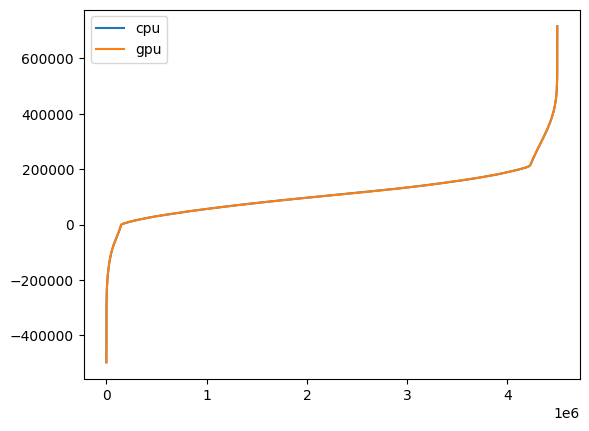

In [12]:
def verify(a, b, decimal, plot):
  if plot == True:
    plt.plot(a, label="cpu")
    plt.plot(b, label="gpu")
    plt.legend()
    plt.show()
  np.testing.assert_almost_equal(a, b, decimal=decimal, )


verify(cpu_res, gpu_res, decimal=2, plot=True)